In [1]:
import os
import sys

import numpy as np
import itertools

from tqdm import tqdm
import re

In [2]:
data_dir = '/hpc/compgen/projects/nanoxog/babe/analysis/mpages/genome_kmer_counts'

In [3]:
kmer_size = 9
pattern = 'k' + str(kmer_size)

In [4]:
matching_files = list()
for f in os.listdir(data_dir):
    if re.search(pattern, f):
        matching_files.append(f)

In [5]:
counts_list = list()
names_list = list()
for f in matching_files:
    counts = np.zeros((4**kmer_size, ), dtype = np.float64)
    with open(os.path.join(data_dir, f), 'r') as of:
        for i, line in enumerate(of):
            counts[i] = int(line.split('\t')[1].strip('\n'))
            
    counts /= np.sum(counts)
    counts_list.append(counts)
    names_list.append(" ".join(f.split('_')[:-1]))
X = np.vstack(counts_list)

In [6]:
X = np.vstack(counts_list)

In [7]:
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import single, leaves_list, dendrogram
from matplotlib import pyplot as plt

In [8]:
dist = pdist(X, 'jensenshannon')

In [9]:
Z = single(dist)
order = leaves_list(Z)

In [10]:
order = leaves_list(Z)

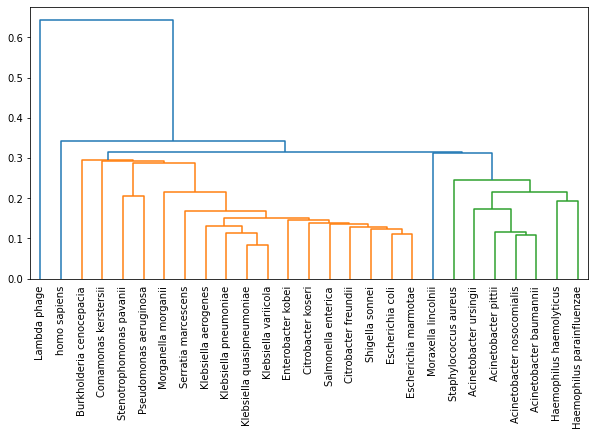

In [153]:
fig = plt.figure(figsize=(10, 5))
dendrogram(Z, labels = names_list, leaf_rotation = 90, color_threshold = 0.3)
plt.show()
fig.savefig('', dpi=fig.dpi, bbox_inches='tight')

In [142]:
with open('/hpc/compgen/projects/nanoxog/babe/analysis/mpages/split_files/clustering_species_order.txt', 'w') as f:
    for s in np.array(names_list)[order].tolist():
        f.write(s + '\n')

In [143]:
dist_matrix = squareform(dist)
dist_matrix = dist_matrix[order, ]
dist_matrix = dist_matrix[:, order]

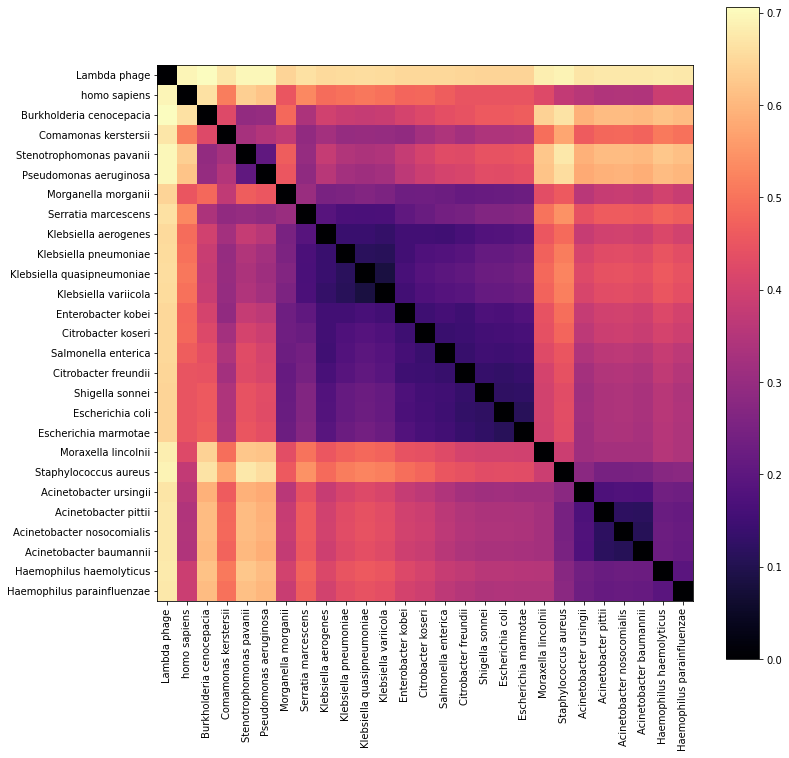

In [144]:
plt.figure(figsize = (12, 12))
plt.imshow(dist_matrix, cmap = plt.get_cmap('magma'))
plt.xticks(np.arange(0, len(names_list), 1), labels = np.array(names_list)[order], rotation = 90)
plt.yticks(np.arange(0, len(names_list), 1), labels = np.array(names_list)[order])
plt.colorbar()
plt.show()

In [146]:
np.savetxt('/hpc/compgen/projects/nanoxog/babe/analysis/mpages/split_files/dist_matrix.txt', dist_matrix)

In [147]:
dist_matrix = np.loadtxt('/hpc/compgen/projects/nanoxog/babe/analysis/mpages/split_files/dist_matrix.txt')

In [16]:
s = 0
d = np.max(dist_matrix) / divisions
n = np.max(dist_matrix) / divisions
bin_matrix = np.zeros(dist_matrix.shape)
for i in range(divisions+1):
    bin_matrix[ (dist_matrix > s) & (dist_matrix <= n) ] = i
    s = n
    n += d

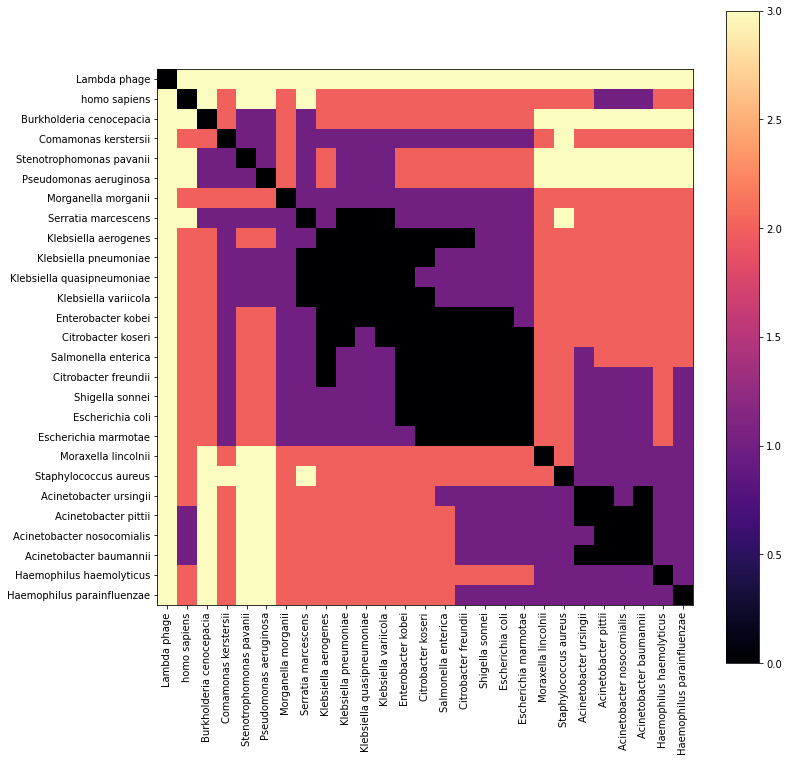

In [18]:
plt.figure(figsize = (12, 12))
plt.imshow(bin_matrix, cmap = plt.get_cmap('magma'))
plt.xticks(np.arange(0, len(names_list), 1), labels = np.array(names_list)[order], rotation = 90)
plt.yticks(np.arange(0, len(names_list), 1), labels = np.array(names_list)[order])
plt.colorbar()
plt.show()

In [150]:
np.savetxt('/hpc/compgen/projects/nanoxog/babe/analysis/mpages/split_files/dist_binarized_matrix.txt', bin_matrix)

In [31]:
available_pos = np.arange(0, len(names_list), 1)
np.random.seed(3)
chosen = np.random.choice(available_pos, size = 1)



available_pos = np.delete(available_pos, np.where(available_pos == chosen)[0])

In [35]:
chosen = np.array([10, 23])

In [39]:
bin_matrix[chosen].min(0)

array([3., 1., 2., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 1., 1.])

In [2]:
import os
import sys
sys.path.append('../src')
sys.path.append('../scripts')
import seeds
import numpy as np
from copy import deepcopy

from benchmark.split_data import interspecies_split

In [3]:
spe_names, chosen = interspecies_split('/hpc/compgen/projects/nanoxog/babe/analysis/mpages/clustering/nohomolambda/distance_matrix_binarized_3_k9.txt', 
                   '/hpc/compgen/projects/nanoxog/babe/analysis/mpages/clustering/nohomolambda/clustering_species_order_k9.txt',
                    12, 10)

Species in train:
Klebsiella variicola
Serratia marcescens
Klebsiella quasipneumoniae
Comamonas kerstersii
Citrobacter koseri
Klebsiella pneumoniae
Enterobacter kobei
Salmonella enterica
Klebsiella aerogenes
Morganella morganii
Species in test:
Burkholderia cenocepacia: 1.0
Stenotrophomonas pavanii: 1.0
Pseudomonas aeruginosa: 1.0
Citrobacter freundii: 0.0
Shigella sonnei: 0.0
Escherichia coli: 0.0
Escherichia marmotae: 0.0
Moraxella lincolnii: 1.0
Staphylococcus aureus: 2.0
Acinetobacter ursingii: 1.0
Acinetobacter pittii: 1.0
Acinetobacter nosocomialis: 1.0
Acinetobacter baumannii: 1.0
Haemophilus haemolyticus: 1.0
Haemophilus parainfluenzae: 1.0


In [4]:
np.array(spe_names)[chosen]

array(['Klebsiella variicola', 'Serratia marcescens',
       'Klebsiella quasipneumoniae', 'Comamonas kerstersii',
       'Citrobacter koseri', 'Klebsiella pneumoniae',
       'Enterobacter kobei', 'Salmonella enterica',
       'Klebsiella aerogenes', 'Morganella morganii'], dtype='<U26')

In [5]:
main_dir = '/hpc/compgen/projects/nanoxog/raw/benchmark'

In [6]:
train_species = np.array(spe_names)[chosen]
test_species = [s for s in spe_names if s not in train_species]

In [7]:
import pandas as pd
from tqdm import tqdm

In [8]:
subdirs = list()
for d in os.listdir(main_dir):
    for dd in os.listdir(os.path.join(main_dir, d)):
        subdirs.append(os.path.join(main_dir, d, dd))

In [45]:
import glob
dirs = glob.glob(os.path.join(main_dir, '*/*/'))

In [9]:
import re

train_dirs = dict()

for train_s in train_species:
    train_s = train_s.replace(' ', '_')
    train_dirs[train_s] = list()
    for dd in subdirs:
        if re.search(train_s, dd):
            train_dirs[train_s].append(dd)

In [10]:
max_reads_train = 50000
max_reads_test = 25000

In [15]:
train_test_ratio

2.0

In [11]:
reads_per_spe = (max_reads_train + max_reads_test)/len(train_dirs)
train_test_ratio = max_reads_train/max_reads_test

In [27]:
import random

In [33]:
for spe, dirs in tqdm(train_dirs.items()):
    
    df_list = list()
    for d in dirs:
        df_list.append(pd.read_csv(os.path.join(d, 'segmentation_report.txt'), sep = '\t', header = None))
        
    df = pd.concat(df_list)
    df = df[df[2] == 'Success']
    
    available_reads = len(df)
    if available_reads > reads_per_spe:
        num_train_reads = int((reads_per_spe/(train_test_ratio + 1)) * train_test_ratio)
        num_test_reads = int(reads_per_spe/(train_test_ratio + 1))
    else:
        num_train_reads = int((available_reads/(train_test_ratio + 1)) * train_test_ratio)
        num_test_reads = int(available_reads/(train_test_ratio + 1))
    
    read_files = sorted(df[0].tolist())
    random.seed(1)
    random.shuffle(read_files)
    
    train_files = read_files[:num_train_reads]
    test_files = read_files[num_train_reads:num_test_reads + num_train_reads]
    

100%|███████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.31it/s]


In [33]:
df = pd.concat(df_list)

In [39]:
df[df[2] == 'Success']

,0,1,2,3,4,5,6
0,/hpc/compgen/projects/nanoxog/raw/wick_benchma...,80e96227-6d59-4525-b211-e27f95e1f560,Success,4259529,4267428,+,NZ_CP054254.1
1,/hpc/compgen/projects/nanoxog/raw/wick_benchma...,6abf2ab7-d7f3-4bb0-b15f-9edf216b6d0a,Success,4241256,4247179,-,NZ_CP054254.1
2,/hpc/compgen/projects/nanoxog/raw/wick_benchma...,3b9fa612-9ec5-4408-8ce0-c0d693a58a98,Success,3867008,3870634,+,NZ_CP054254.1
4,/hpc/compgen/projects/nanoxog/raw/wick_benchma...,27e9392e-7aa4-4744-acc2-4fa5fe99fba6,Success,767494,772855,-,NZ_CP054254.1
6,/hpc/compgen/projects/nanoxog/raw/wick_benchma...,c61d456c-ec51-4cc9-9028-167a78465f12,Success,1194484,1201823,-,NZ_CP054254.1
...,...,...,...,...,...,...,...
6496,/hpc/compgen/projects/nanoxog/raw/wick_benchma...,1bbd5167-cbeb-4217-8324-61284aba484d,Success,4309292,4331304,+,NZ_CP054254.1
6497,/hpc/compgen/projects/nanoxog/raw/wick_benchma...,29800cbb-06e6-4b1d-ad9b-00df700e1563,Success,314209,341084,-,NZ_CP054254.1
6498,/hpc/compgen/projects/nanoxog/raw/wick_benchma...,d7050cb5-1ce1-4293-ac4e-41148d7a124d,Success,2710128,2733466,-,NZ_CP054254.1
6499,/hpc/compgen/projects/nanoxog/raw/wick_benchma...,d13d6dea-a471-47b4-bc5e-0a867f726f8a,Success,5385482,5422540,+,NZ_CP054254.1
